In [11]:
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
import h5py

# Load the UMIST dataset from .mat file
mat_file_path = 'umist_cropped.mat'
mat_data = scipy.io.loadmat(mat_file_path)


In [12]:
# Extract facedat and dirnames
facedat = mat_data['facedat'][0]
dirnames = mat_data['dirnames'][0]

# Create lists to store processed images and labels
images = []
labels = []


In [13]:
# Process each person's data
# Alternative with padding (if you need numpy array output)
max_width = max(max(img.shape[1] for img in person_data if len(img) > 0) for person_data in facedat)
padded_images = []

for person_data in facedat:
    for img in person_data:
        if isinstance(img, np.ndarray) and img.size > 0:
            padded = np.zeros((92, max_width))
            padded[:, :img.shape[1]] = img
            padded_images.append(padded)

images = np.array(padded_images)
labels = np.repeat(np.arange(len(facedat)), [len(person_data) for person_data in facedat if len(person_data) > 0])
##Outher loop iterates thorugh each person's data (Subject),
### Inner Loop iterates thorugh each image of that person 
###Structure: facedat is nested array where facedat[i] contains all images for person i

#

In [14]:
##Converting labels to numpy arrays
labels = np.array(labels)
###labels is a list of integers where each integer represents the person in the image

In [15]:
# First split: temporary train (85%) and test (15%)
indices = np.arange(len(images))
idx_temp_train, idx_test, y_temp_train, y_test = train_test_split(
    indices, 
    labels,
    test_size=0.15,  ##Test size is 15% of the data (85% is for training)
    stratify=labels, ##Stratification is used to ensure that the train and test sets have the same distribution of labels
    random_state=42 ##Random state is used to ensure reproducibility
)

In [16]:
# Second split: final train (70%) and validation (15%)
idx_train, idx_val, y_train, y_val = train_test_split(
    idx_temp_train,
    y_temp_train,
    test_size=0.176,
    stratify=y_temp_train,
    random_state=42
)

##In the second train-test split, the temporary train set is split into the final train and validation sets
##The final train set is 70% of the data and the validation set is 15% of the data
##Remanining 15% of the data is used for testing


In [17]:
X_train = [images[i] for i in idx_train]
X_val = [images[i] for i in idx_val]
X_test = [images[i] for i in idx_test]

In [18]:
print("\nDataset Split Sizes:")
print(f"Training set: {len(X_train)} images ({len(X_train)/len(images)*100:.1f}%)")
print(f"Validation set: {len(X_val)} images ({len(X_val)/len(images)*100:.1f}%)")
print(f"Test set: {len(X_test)} images ({len(X_test)/len(images)*100:.1f}%)")


Dataset Split Sizes:
Training set: 1568 images (70.0%)
Validation set: 336 images (15.0%)
Test set: 336 images (15.0%)


In [19]:
def save_split(images, labels, prefix):
    # Find the maximum width to pad all images to the same size
    max_width = max(img.shape[1] for img in images)
    height = images[0].shape[0]  # All images have same height (92)
    
    # Create padded array
    padded_images = np.zeros((len(images), height, max_width))
    
    # Fill the padded array
    for i, img in enumerate(images):
        w = img.shape[1]
        padded_images[i, :, :w] = img
    
    # Save as compressed npz file
    np.savez_compressed(
        f'umist_split_{prefix}.npz',
        images=padded_images,
        labels=labels,
        original_widths=[img.shape[1] for img in images]  # Save original widths for later
    )

In [20]:
# Save all splits
save_split(X_train, y_train, 'train')
save_split(X_val, y_val, 'val')
save_split(X_test, y_test, 'test')

print("\nSaved splits successfully!")
print("Files created:")
print("- umist_split_train.npz")
print("- umist_split_val.npz")
print("- umist_split_test.npz")

# Function to load and verify the saved data
def load_and_verify_split(prefix):
    data = np.load(f'umist_split_{prefix}.npz')
    print(f"\nVerifying {prefix} split:")
    print(f"Images shape: {data['images'].shape}")
    print(f"Labels shape: {data['labels'].shape}")
    print(f"Number of original widths: {len(data['original_widths'])}")
    return data

# Verify saved data
train_data = load_and_verify_split('train')
val_data = load_and_verify_split('val')
test_data = load_and_verify_split('test')


Saved splits successfully!
Files created:
- umist_split_train.npz
- umist_split_val.npz
- umist_split_test.npz

Verifying train split:
Images shape: (1568, 92, 48)
Labels shape: (1568,)
Number of original widths: 1568

Verifying val split:
Images shape: (336, 92, 48)
Labels shape: (336,)
Number of original widths: 336

Verifying test split:
Images shape: (336, 92, 48)
Labels shape: (336,)
Number of original widths: 336


In [22]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import cv2

def preprocess_umist_data(images, labels):
    """
    Comprehensive preprocessing pipeline for UMIST dataset
    """
    # 1. Image Normalization
    # Convert to float32 for better numerical precision
    normalized_images = np.array([img.astype(np.float32) for img in images])
    
    # Min-max normalization to [0,1] range
    normalized_images = np.array([
        (img - np.min(img)) / (np.max(img) - np.min(img))
        for img in normalized_images
    ])
    
    # 2. Histogram Equalization for better contrast
    equalized_images = np.array([
        cv2.equalizeHist((img * 255).astype(np.uint8)).astype(np.float32) / 255
        for img in normalized_images
    ])
    
    # 3. Standardization (z-score normalization)
    # Reshape to 2D array for StandardScaler
    n_samples = len(equalized_images)
    n_features = equalized_images[0].size
    X = equalized_images.reshape(n_samples, -1)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 4. PCA for dimensionality reduction
    # Keep 95% of variance
    pca = PCA(n_components=0.95, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    print("\nPreprocessing Summary:")
    print(f"Original shape: {images[0].shape}")
    print(f"After flattening: {X.shape}")
    print(f"After PCA: {X_pca.shape}")
    print(f"Variance explained ratio: {np.sum(pca.explained_variance_ratio_):.3f}")
    print(f"Number of components kept: {pca.n_components_}")
    
    return X_pca, pca, scaler

# Apply preprocessing
X_processed, pca, scaler = preprocess_umist_data(images, labels)


Preprocessing Summary:
Original shape: (92, 48)
After flattening: (2240, 4416)
After PCA: (2240, 139)
Variance explained ratio: 0.950
Number of components kept: 139


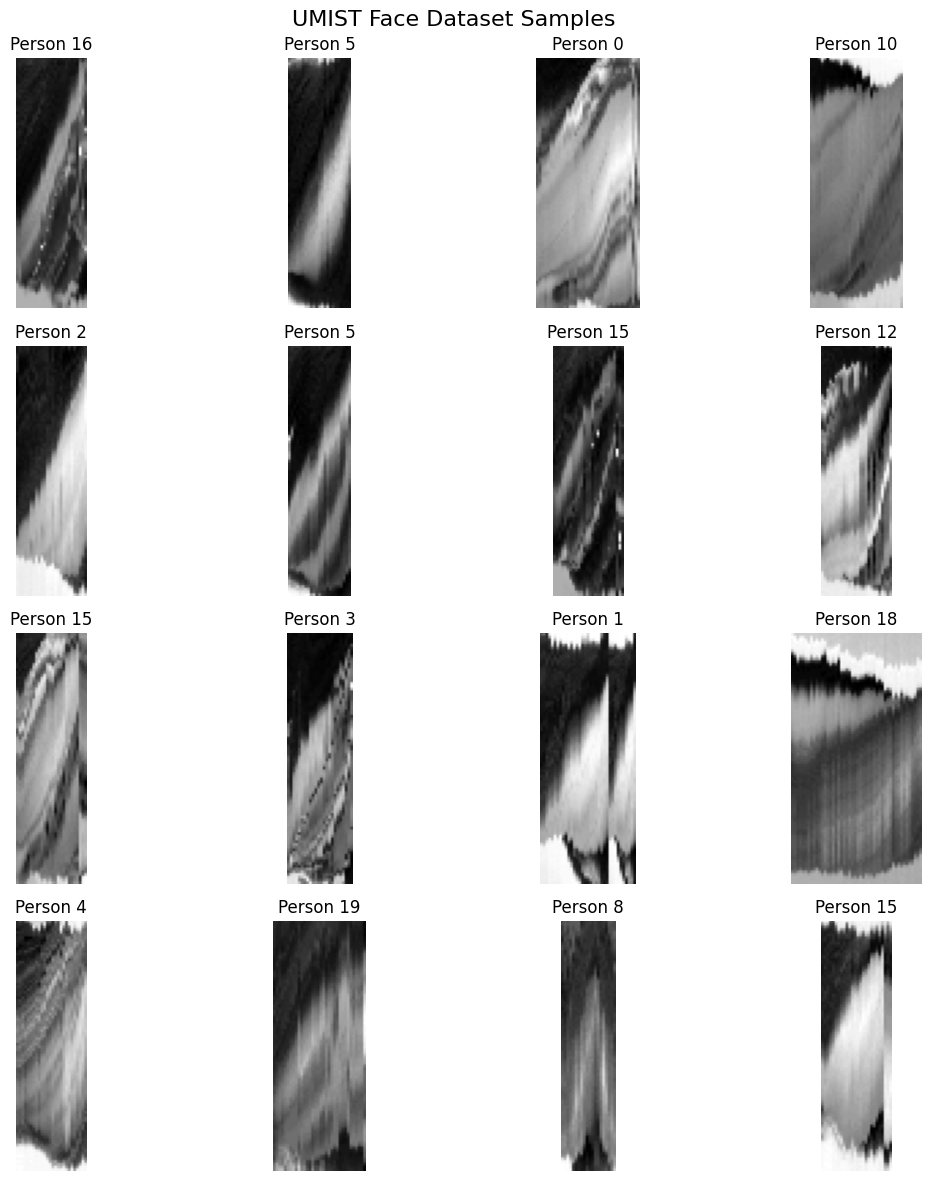

In [1]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np

# Load the UMIST dataset
mat_data = scipy.io.loadmat('umist_cropped.mat')
facedat = mat_data['facedat'][0]

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('UMIST Face Dataset Samples', fontsize=16)

# Flatten axes for easier iteration
axes = axes.ravel()

# Plot 16 random images
for idx in range(16):
    # Select random person and image
    person_idx = np.random.randint(0, len(facedat))
    person_images = facedat[person_idx]
    if len(person_images) > 0:
        img_idx = np.random.randint(0, len(person_images))
        img = person_images[img_idx]
        
        # Display image
        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f'Person {person_idx}')

plt.tight_layout()
plt.show()